<a href="https://colab.research.google.com/github/krishnakumarreddy007/64061_ktavva/blob/main/Assignment%2002%20Convolution%20Networks/Assignment_2_e_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AML Assignment 2 - Convolution Networks - Cats & Dogs dataset

Name: Krishna Kumar Tavva

Due Date: 14-Jul-2024

Load all the required libraries

In [ ]:
!pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import zipfile
import io
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from io import BytesIO
from zipfile import ZipFile

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tkkreddy","key":"a12d359326e4b61bac0e5612cdbf7bf9"}'}

**Create a Keggle folder**

In [ ]:
!mkdir ~/.kaggle

# Copy the keggle json to folder created
!cp kaggle.json ~/.kaggle/

# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# List all the datasets in Kaggle
! kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                         📚 Students Performance Dataset 📚                     66KB  2024-06-12 23:09:20          16943        365  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                   Most Streamed Spotify Songs 2024                    496KB  2024-06-15 18:50:51          12720        268  1.0              
priyamchoksi/spotify-dataset-114k-songs                             114000 Spotify Songs                                  8MB  2024-07-07 17:12:18            727         26  1.0              
ihelon/coffee-sales                     

Download the Dogs and Cats Dataset

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:36<00:00, 27.5MB/s]
100% 812M/812M [00:36<00:00, 23.2MB/s]


Unzipping the data

In [ ]:
!unzip -qq dogs-vs-cats.zip

Unzipping the training data

In [ ]:
!unzip -qq train.zip

 **1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?**

Dividing the dataset into three sample sets: training = 1000, validation = 500, and test = 500

In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)


Data Pre-Processing - Using image_dataset_from_directory to read images and functions

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Viewing the shape of the images



In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers : Instantiating a small convnet for dogs vs. cats classification

In [ ]:
#Building the model
#Instantiating a small convnet for dogs vs. cats classification
#*Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers*

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

Model 1: Training

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_1 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/20
63/63 [==============================] - 19s 280ms/step - loss: 0.6891 - accuracy: 0.5335 - val_loss: 0.6522 - val_accuracy: 0.6140
Epoch 2/20
63/63 [==============================] - 17s 272ms/step - loss: 0.6685 - accuracy: 0.5845 - val_loss: 0.6695 - val_accuracy: 0.5710
Epoch 3/20
63/63 [==============================] - 17s 270ms/step - loss: 0.6455 - accuracy: 0.6265 - val_loss: 0.6443 - val_accuracy: 0.6280
Epoch 4/20
63/63 [==============================] - 17s 271ms/step - loss: 0.6198 - accuracy: 0.6665 - val_loss: 0.6066 - val_accuracy: 0.6710
Epoch 5/20
63/63 [==============================] - 17s 266ms/step - loss: 0.5829 - accuracy: 0.6950 - val_loss: 0.6316 - val_accuracy: 0.6480
Epoch 6/20
63/63 [==============================] - 17s 267ms/step - loss: 0.5402 - accuracy: 0.7125 - val_loss: 0.5471 - val_accuracy: 0.7300
Epoch 7/20
63/63 [==============================] - 17s 264ms/step - loss: 0.4894 - accuracy: 0.7480 - val_loss: 0.5664 - val_accuracy: 0.7210

Plotting Training and Validation Accuracy

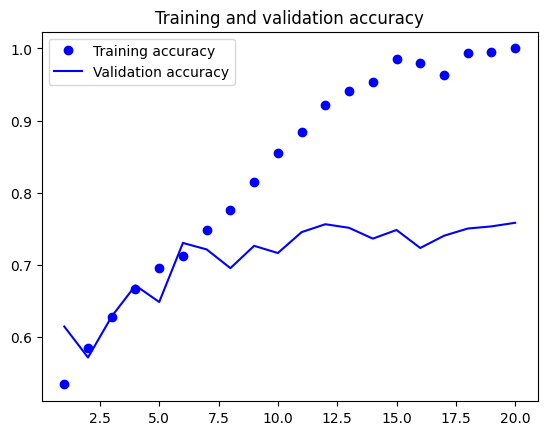

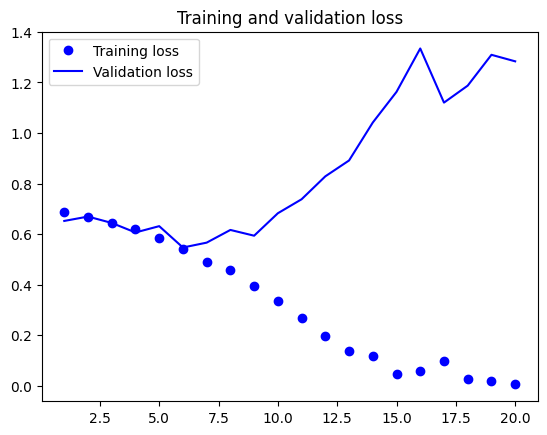

In [ ]:
import matplotlib.pyplot as plt

accuracy = Model_1.history["accuracy"]
val_accuracy = Model_1.history["val_accuracy"]
loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the performance of Model 1 on the test set

In [ ]:
test_model = keras.models.load_model("model1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 52ms/step - loss: 0.5663 - accuracy: 0.7080
Loss: 0.566
Accuracy: 0.708


Using Measures to Avoid Overfitting

Data Augmentation

In [ ]:
# To deprecate warnings that are making the output look clumsy

import logging

logging.getLogger('tensorflow').disabled = True

Using few of the techniques such as random flip, random zoom, random rotation so as to create augmented versions of the image

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

Looking at the augmented images

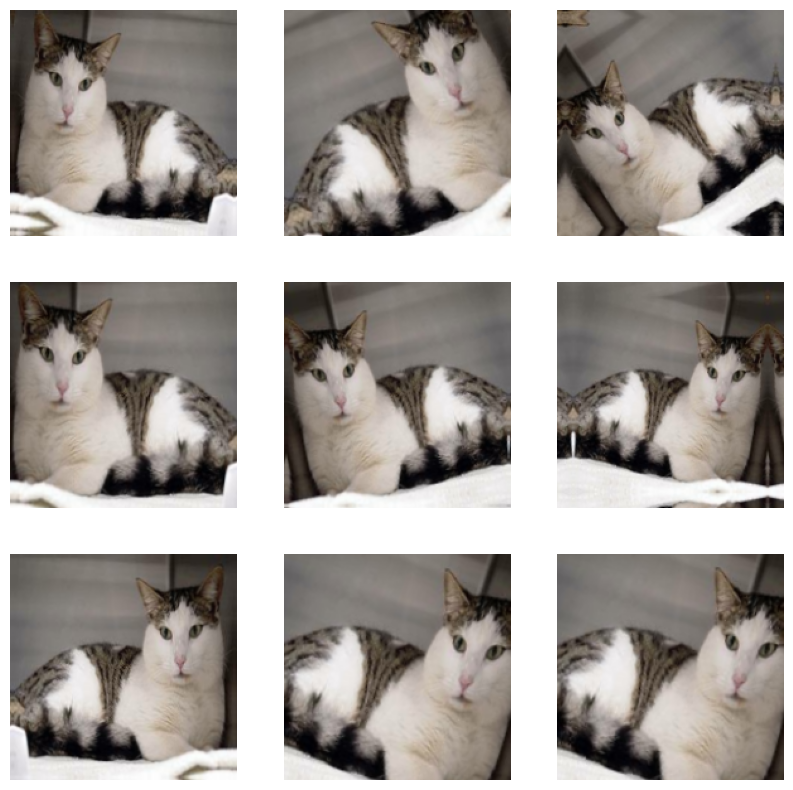

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

Model - 2 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Model 2: Training

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Fitting the Model

Model_2 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/20
63/63 [==============================] - 19s 284ms/step - loss: 0.6966 - accuracy: 0.5120 - val_loss: 0.6800 - val_accuracy: 0.5130
Epoch 2/20
63/63 [==============================] - 18s 281ms/step - loss: 0.6853 - accuracy: 0.5605 - val_loss: 0.6727 - val_accuracy: 0.5640
Epoch 3/20
63/63 [==============================] - 18s 283ms/step - loss: 0.6730 - accuracy: 0.5900 - val_loss: 0.6696 - val_accuracy: 0.5940
Epoch 4/20
63/63 [==============================] - 18s 279ms/step - loss: 0.6464 - accuracy: 0.6235 - val_loss: 0.6303 - val_accuracy: 0.6370
Epoch 5/20
63/63 [==============================] - 17s 275ms/step - loss: 0.6258 - accuracy: 0.6650 - val_loss: 0.6727 - val_accuracy: 0.5550
Epoch 6/20
63/63 [==============================] - 17s 271ms/step - loss: 0.6333 - accuracy: 0.6540 - val_loss: 0.6186 - val_accuracy: 0.6550
Epoch 7/20
63/63 [==============================] - 17s 276ms/step - loss: 0.6356 - accuracy: 0.6545 - val_loss: 0.6286 - val_accuracy: 0.6450

Visualizing the Training and Validation Accuracy/Loss of Model 2

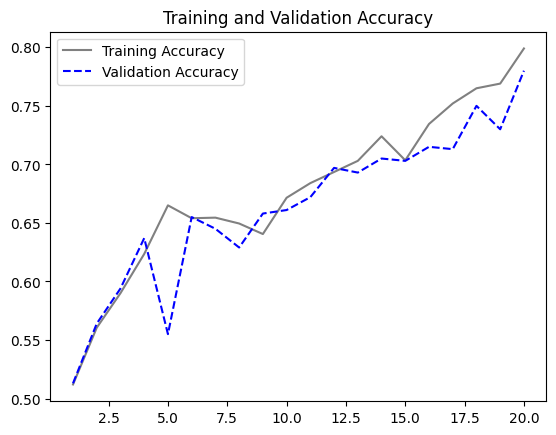

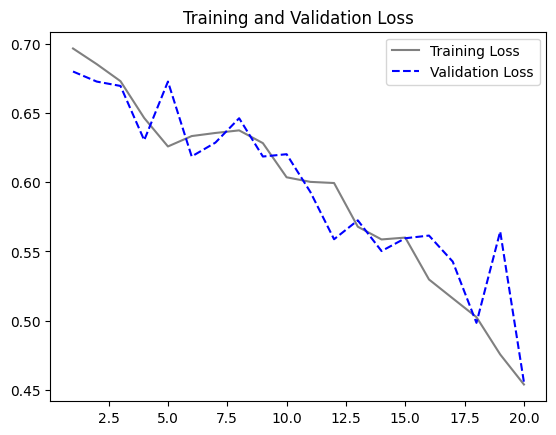

In [ ]:
accuracy = Model_2.history["accuracy"]
val_accuracy = Model_2.history["val_accuracy"]
loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 2 on the test set

In [ ]:
test_model = keras.models.load_model("model2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")


32/32 [==============================] - 2s 55ms/step - loss: 0.5118 - accuracy: 0.7560
Loss: 0.512
Accuracy: 0.756


Comparing the Model 1 and Model 2 : we can clearly see that the accuracy rate of model 2 is higher than model 1

Model - 3 MaxPooling Operation with Increase in filters from 32 to 512 in 6 Input Layers with the use of Augmented Images and Dropout rate of 0.3

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Summary

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

Model 3 Training

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ["accuracy"])


# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model3.keras",
            save_best_only= True,
            monitor= "val_loss")


# Fitting the model
Model_3 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/20
63/63 [==============================] - 19s 281ms/step - loss: 0.6946 - accuracy: 0.5075 - val_loss: 0.6922 - val_accuracy: 0.5010
Epoch 2/20
63/63 [==============================] - 17s 276ms/step - loss: 0.6929 - accuracy: 0.4980 - val_loss: 0.6865 - val_accuracy: 0.5940
Epoch 3/20
63/63 [==============================] - 17s 268ms/step - loss: 0.6867 - accuracy: 0.5450 - val_loss: 0.7255 - val_accuracy: 0.5250
Epoch 4/20
63/63 [==============================] - 17s 269ms/step - loss: 0.6774 - accuracy: 0.5935 - val_loss: 0.6478 - val_accuracy: 0.6150
Epoch 5/20
63/63 [==============================] - 17s 268ms/step - loss: 0.6655 - accuracy: 0.5990 - val_loss: 0.6353 - val_accuracy: 0.6270
Epoch 6/20
63/63 [==============================] - 17s 265ms/step - loss: 0.6576 - accuracy: 0.6215 - val_loss: 0.7187 - val_accuracy: 0.5980
Epoch 7/20
63/63 [==============================] - 17s 265ms/step - loss: 0.6547 - accuracy: 0.6065 - val_loss: 0.6438 - val_accuracy: 0.6390

Visualizing the Training and Validation Accuracy/Loss of Model 3

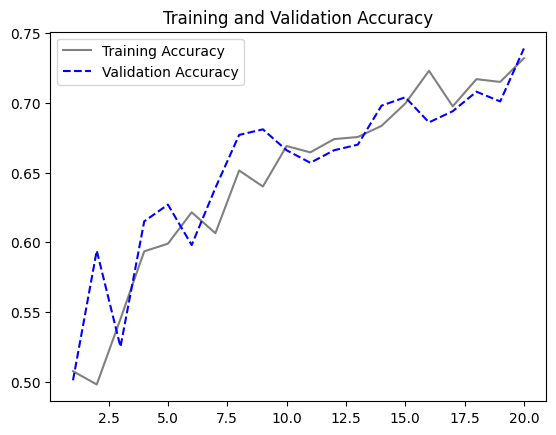

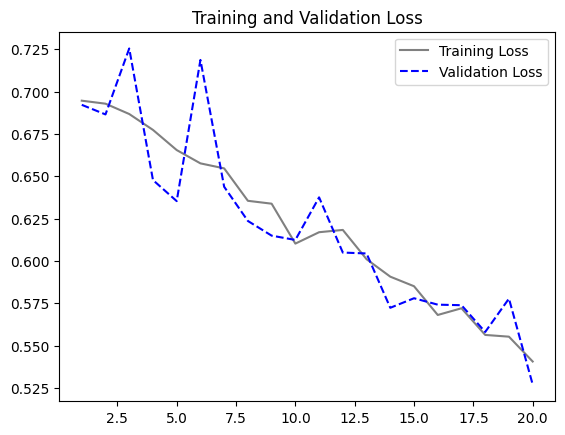

In [ ]:
accuracy = Model_3.history["accuracy"]
val_accuracy = Model_3.history["val_accuracy"]
loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 3 on the test set

In [ ]:
test_model = keras.models.load_model("model3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")


32/32 [==============================] - 2s 53ms/step - loss: 0.5558 - accuracy: 0.7240
Loss: 0.556
Accuracy: 0.724


Model - 4 MaxPooling Operation with Increase in filters from 64 to 1024 in 5 Input Layers with the use of Augmented Images and Dropout rate of 0.5

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Summary

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 128)       73856     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_4 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/20
63/63 [==============================] - 58s 892ms/step - loss: 0.7083 - accuracy: 0.4975 - val_loss: 0.6926 - val_accuracy: 0.5730
Epoch 2/20
63/63 [==============================] - 57s 901ms/step - loss: 0.6929 - accuracy: 0.5265 - val_loss: 0.6885 - val_accuracy: 0.5570
Epoch 3/20
63/63 [==============================] - 56s 888ms/step - loss: 0.6917 - accuracy: 0.5155 - val_loss: 0.6835 - val_accuracy: 0.5920
Epoch 4/20
63/63 [==============================] - 56s 889ms/step - loss: 0.6908 - accuracy: 0.5185 - val_loss: 0.6808 - val_accuracy: 0.5720
Epoch 5/20
63/63 [==============================] - 56s 892ms/step - loss: 0.6955 - accuracy: 0.5280 - val_loss: 0.6915 - val_accuracy: 0.5150
Epoch 6/20
63/63 [==============================] - 55s 881ms/step - loss: 0.6914 - accuracy: 0.5065 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 7/20
63/63 [==============================] - 56s 885ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6957 - val_accuracy: 0.4990

Visualizing the Training and Validation Accuracy/Loss

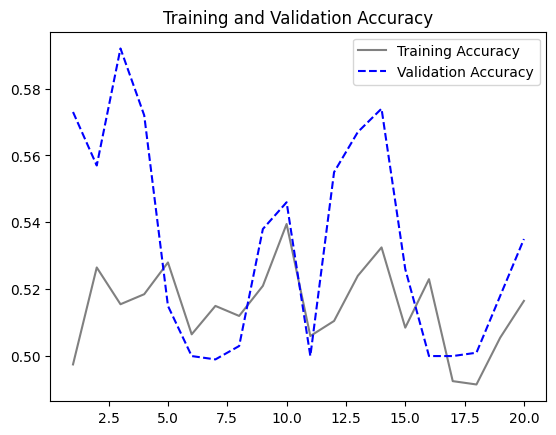

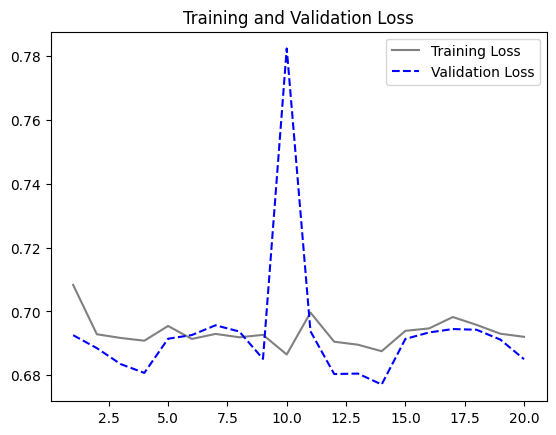

In [ ]:
accuracy = Model_4.history["accuracy"]
val_accuracy = Model_4.history["val_accuracy"]
loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 4 on the test set

In [ ]:
test_model = keras.models.load_model("model4.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 126ms/step - loss: 0.6879 - accuracy: 0.5580
Loss: 0.688
Accuracy: 0.558




Summary for Question 1: We tried to build 4 models with the training sample being 1000. If we compare the loss and Accuracy of these models

Model 1: filters from 32 to 256, 5 Input Layers

Model 2: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3

Model 3: filters from 32 to 512, 6 Input Layers, Augmented Images and Dropout rate of 0.3

Model 4: filters from 64 to 1024, 5 Input Layers, Augmented Images and Dropout rate of 0.5


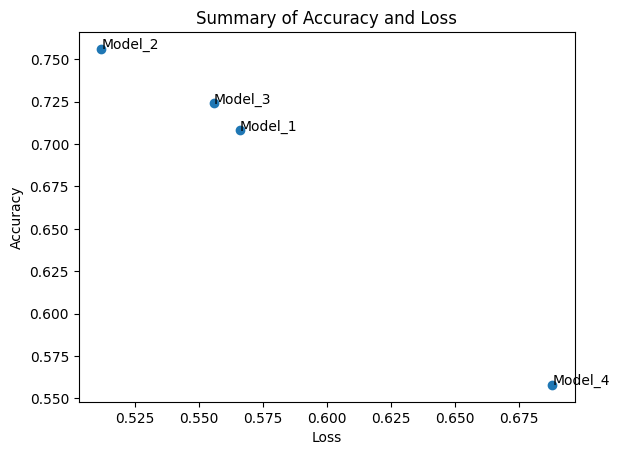

In [ ]:
import matplotlib.pyplot as plt

Model_1 = (0.566, 0.708)
Model_2 = (0.512, 0.756)
Model_3 = (0.556, 0.724)
Model_4 = (0.688, 0.558)

Models = ("Model_1","Model_2","Model_3","Model_4")
Loss = (Model_1[0],Model_2[0],Model_3[0],Model_4[0])
Accuracy = (Model_1[1],Model_2[1],Model_3[1],Model_4[1])

fig, ax = plt.subplots()
ax.scatter(Loss,Accuracy)
for i, txt in enumerate(Models):
    ax.annotate(txt, (Loss[i],Accuracy[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

Conclusions: From the above, we can conclude that Model 2 is the best among all with higher accuracy and minimum loss. Notably, Model 4 has the highest loss.

Recommendation: Model 2 is best performing model i.e. with filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3

**2.Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

Considering training sample, train=1500, validation = 500, test = 500


In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)


Data Pre-Processing

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Viewing the size of the images

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Viewing the size of the images

In [ ]:
data_augmentation_1 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

Model - 5 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

Model 5: Training

In [ ]:
# Compiling the model

model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath = "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Fitting the model

Model_5 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/20
94/94 [==============================] - 27s 270ms/step - loss: 0.6905 - accuracy: 0.5250 - val_loss: 0.6785 - val_accuracy: 0.5740
Epoch 2/20
94/94 [==============================] - 25s 266ms/step - loss: 0.6807 - accuracy: 0.5663 - val_loss: 0.6795 - val_accuracy: 0.5810
Epoch 3/20
94/94 [==============================] - 25s 263ms/step - loss: 0.6675 - accuracy: 0.5970 - val_loss: 0.6777 - val_accuracy: 0.5670
Epoch 4/20
94/94 [==============================] - 25s 266ms/step - loss: 0.6542 - accuracy: 0.6137 - val_loss: 0.6598 - val_accuracy: 0.6000
Epoch 5/20
94/94 [==============================] - 25s 267ms/step - loss: 0.6397 - accuracy: 0.6303 - val_loss: 0.6688 - val_accuracy: 0.5880
Epoch 6/20
94/94 [==============================] - 25s 264ms/step - loss: 0.6233 - accuracy: 0.6593 - val_loss: 0.6383 - val_accuracy: 0.6330
Epoch 7/20
94/94 [==============================] - 25s 262ms/step - loss: 0.6078 - accuracy: 0.6707 - val_loss: 0.6242 - val_accuracy: 0.6520

Visualizing the Training and Validation Accuracy/Loss

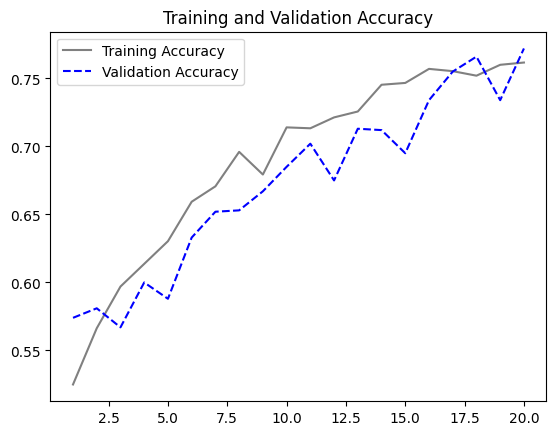

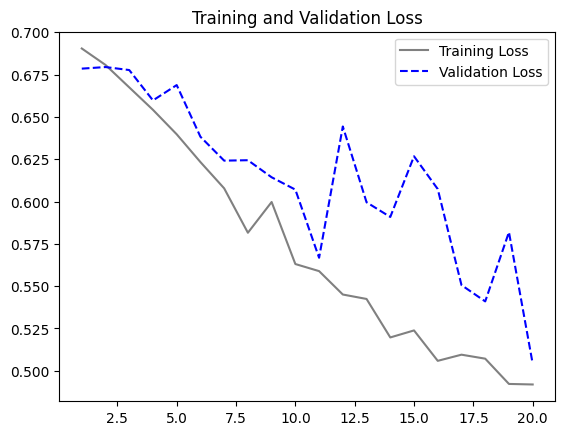

In [ ]:
accuracy = Model_5.history["accuracy"]
val_accuracy = Model_5.history["val_accuracy"]
loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 5 on the test set

In [ ]:
test_model = keras.models.load_model("model5.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 52ms/step - loss: 0.4665 - accuracy: 0.7810
Loss: 0.467
Accuracy: 0.781


Summary: Model 2 built with 1000 training samples resulted in 72% accuracy, whereas the same model with an increase in training samples to 1500 spiked the accuracy to 76.4%

Model - 6 Strides Operation with Padding being "Same" with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 1500)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 90, 90, 32)        896       
                                                                 
 conv2d_27 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 256)       2951

Model 6: Training

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model6.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_6 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/20
94/94 [==============================] - 8s 72ms/step - loss: 0.6931 - accuracy: 0.5243 - val_loss: 0.6866 - val_accuracy: 0.5610
Epoch 2/20
94/94 [==============================] - 7s 70ms/step - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6926 - val_accuracy: 0.5100
Epoch 3/20
94/94 [==============================] - 6s 67ms/step - loss: 0.6937 - accuracy: 0.5123 - val_loss: 0.6919 - val_accuracy: 0.4990
Epoch 4/20
94/94 [==============================] - 6s 68ms/step - loss: 0.6934 - accuracy: 0.5157 - val_loss: 0.6919 - val_accuracy: 0.5060
Epoch 5/20
94/94 [==============================] - 6s 68ms/step - loss: 0.6904 - accuracy: 0.5400 - val_loss: 0.6926 - val_accuracy: 0.5180
Epoch 6/20
94/94 [==============================] - 6s 69ms/step - loss: 0.6937 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 7/20
94/94 [==============================] - 6s 69ms/step - loss: 0.6933 - accuracy: 0.4970 - val_loss: 0.6923 - val_accuracy: 0.4960
Epoch 8/20
94

Visualizing the Training and Validation Accuracy/Loss

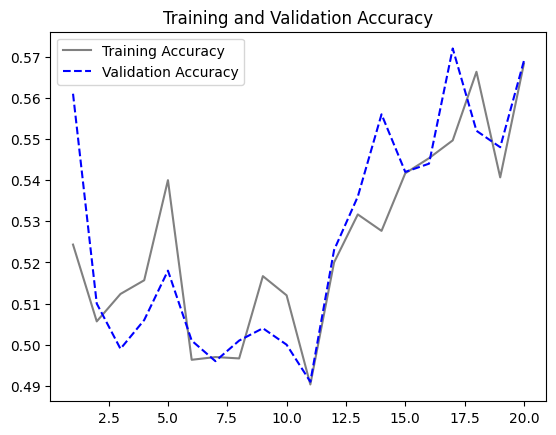

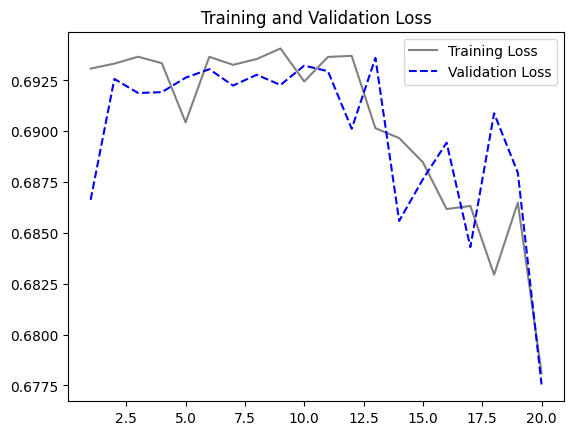

In [ ]:
accuracy = Model_6.history["accuracy"]
val_accuracy = Model_6.history["val_accuracy"]
loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 6 on the test set

In [ ]:
test_model = keras.models.load_model("model6.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.6694 - accuracy: 0.6070
Loss: 0.669
Accuracy: 0.607


Summary for Question 2: We tried to build 2 more models with training sample 1500.

Model 2: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3, training size 1000

Model 5: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3, training size 1500

Model 6: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3, training size 1500, Padding being same

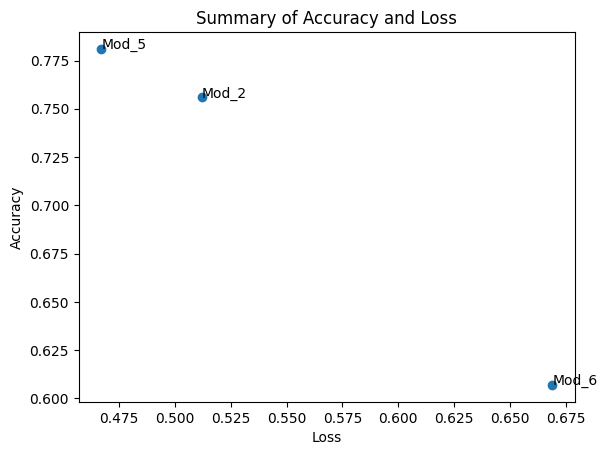

In [ ]:
import matplotlib.pyplot as plt

Model_2 = (0.512, 0.756)
Model_5 = (0.467, 0.781)
Model_6 = (0.669, 0.607)

Models_2 = ("Mod_2","Mod_5","Mod_6")
Loss_2 = (Model_2[0],Model_5[0],Model_6[0])
Accuracy_2 = (Model_2[1],Model_5[1],Model_6[1])

fig, ax = plt.subplots()
ax.scatter(Loss_2,Accuracy_2)
for i, txt in enumerate(Models_2):
    ax.annotate(txt, (Loss_2[i],Accuracy_2[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

Comparing the performance of the models, it was observed that utilizing strides with padding did not significantly benefit the model. Model 5, which incorporated a Max Pooling Layer, exhibited higher accuracy compared to the Strides model. Furthermore, by optimizing the network and increasing the training dataset from 1000 to 1500 samples, an enhanced accuracy of 78.1% was achieved.

To address the second query, we plotted the performance of Model 5 and Model 6, allowing for a visual comparison. The graphs clearly illustrate that Model 5 achieved the highest accuracy among all the models, reaching 78.1%, with the lowest loss of 46.7%. The augmentation of the training samples to 1500 and the introduction of diverse augmented images notably contributed to the improved performance of the model.

**3.Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.**

Increasing the sample size to 1500 and 2000 for better performance

In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)


Model - 7 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model7.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_7 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/20
125/125 [==============================] - 36s 270ms/step - loss: 0.6938 - accuracy: 0.5182 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/20
125/125 [==============================] - 34s 270ms/step - loss: 0.6934 - accuracy: 0.5110 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
125/125 [==============================] - 34s 271ms/step - loss: 0.6935 - accuracy: 0.5010 - val_loss: 0.6928 - val_accuracy: 0.5015
Epoch 4/20
125/125 [==============================] - 34s 270ms/step - loss: 0.6939 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 33s 266ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
125/125 [==============================] - 33s 265ms/step - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 7/20
125/125 [==============================] - 34s 270ms/step - loss: 0.6934 - accuracy: 0.4967 - val_loss: 0.6931 - val_ac

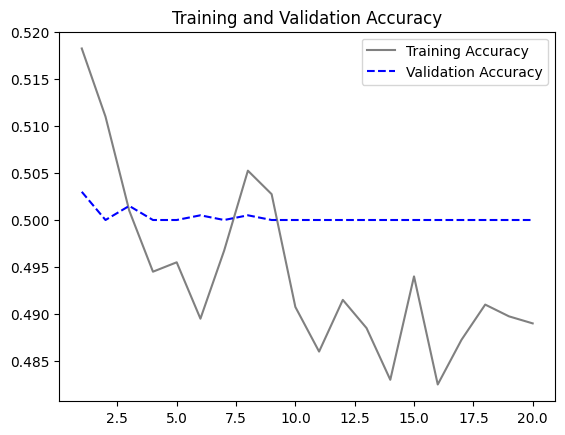

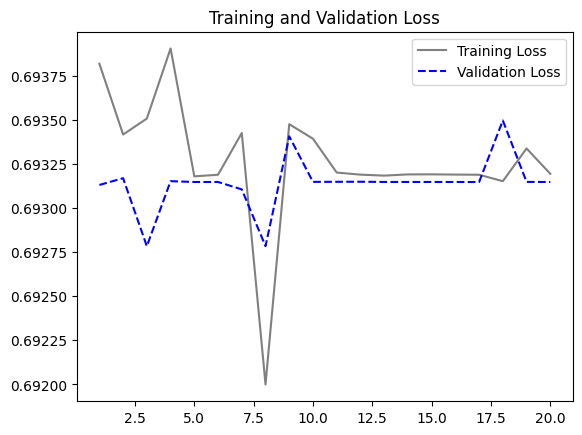

In [ ]:
accuracy = Model_7.history["accuracy"]
val_accuracy = Model_7.history["val_accuracy"]

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model7.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 53ms/step - loss: 0.6929 - accuracy: 0.5010
Loss: 0.693
Accuracy: 0.501


In the previous Model 6, we attempted to replace the conventional max pooling operation with strides, but the results were not as promising as expected. In Model 7, we reverted to using max pooling only. Therefore, we are now exploring a hybrid approach that combines both max pooling and strides to evaluate the performance of this new model.

Max pooling is a downsampling operation that reduces the spatial dimensions of the feature map, aiming to capture the most prominent features while discarding less relevant information. On the other hand, strides determine the step rate of the sliding window used to extract and learn features from the data. This hybrid approach aims to leverage the advantages of both techniques, potentially enhancing the model's ability to capture intricate patterns and features while maintaining computational efficiency.

Model - 8 MaxPooling + Strides of Step-Size 2 Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model8.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_8 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/20
125/125 [==============================] - 36s 273ms/step - loss: 0.6886 - accuracy: 0.5397 - val_loss: 0.7003 - val_accuracy: 0.5970
Epoch 2/20
125/125 [==============================] - 34s 272ms/step - loss: 0.6662 - accuracy: 0.5903 - val_loss: 0.6639 - val_accuracy: 0.6205
Epoch 3/20
125/125 [==============================] - 34s 270ms/step - loss: 0.6469 - accuracy: 0.6202 - val_loss: 0.6394 - val_accuracy: 0.6355
Epoch 4/20
125/125 [==============================] - 33s 267ms/step - loss: 0.6476 - accuracy: 0.6263 - val_loss: 0.6593 - val_accuracy: 0.6515
Epoch 5/20
125/125 [==============================] - 33s 268ms/step - loss: 0.6131 - accuracy: 0.6668 - val_loss: 0.6655 - val_accuracy: 0.6730
Epoch 6/20
125/125 [==============================] - 34s 270ms/step - loss: 0.6020 - accuracy: 0.6727 - val_loss: 0.6369 - val_accuracy: 0.6750
Epoch 7/20
125/125 [==============================] - 34s 269ms/step - loss: 0.5856 - accuracy: 0.6888 - val_loss: 0.5543 - val_ac

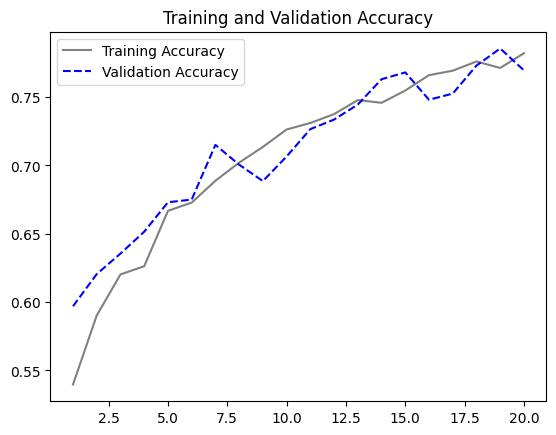

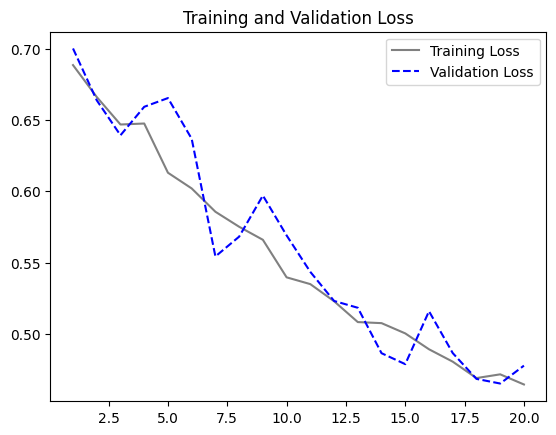

In [ ]:
accuracy = Model_8.history["accuracy"]
val_accuracy = Model_8.history["val_accuracy"]
loss = Model_8.history["loss"]
val_loss = Model_8.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model8.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")


63/63 [==============================] - 4s 54ms/step - loss: 0.4894 - accuracy: 0.7650
Loss: 0.489
Accuracy: 0.765


Model - 9 MaxPooling + Strides of Step-Size 2 with Padding turned on Operation with Increase in filters from 32 to 512 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2, padding="same")(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model9.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_9 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/20
125/125 [==============================] - 39s 298ms/step - loss: 0.6946 - accuracy: 0.4990 - val_loss: 0.6982 - val_accuracy: 0.5020
Epoch 2/20
125/125 [==============================] - 37s 297ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5020
Epoch 3/20
125/125 [==============================] - 37s 295ms/step - loss: 0.6936 - accuracy: 0.5020 - val_loss: 0.6941 - val_accuracy: 0.4850
Epoch 4/20
125/125 [==============================] - 37s 297ms/step - loss: 0.6935 - accuracy: 0.4873 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 37s 296ms/step - loss: 0.6936 - accuracy: 0.5027 - val_loss: 0.6921 - val_accuracy: 0.5105
Epoch 6/20
125/125 [==============================] - 37s 294ms/step - loss: 0.6956 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 7/20
125/125 [==============================] - 37s 294ms/step - loss: 0.6941 - accuracy: 0.5080 - val_loss: 0.6926 - val_ac

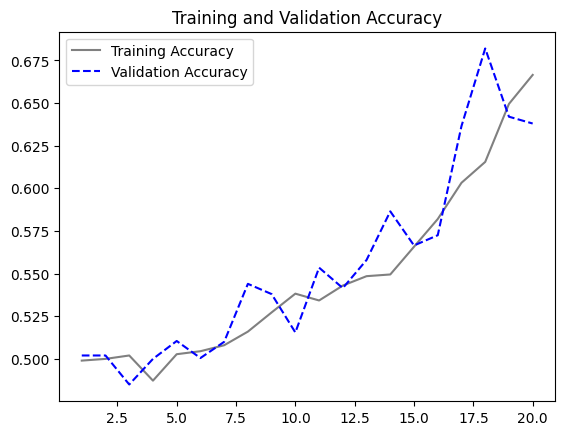

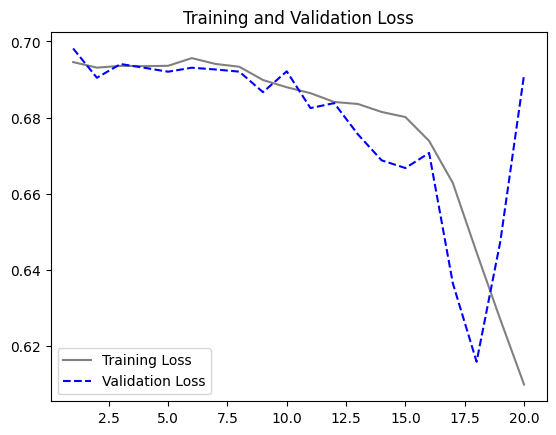

In [ ]:
accuracy = Model_9.history["accuracy"]
val_accuracy = Model_9.history["val_accuracy"]
loss = Model_9.history["loss"]
val_loss = Model_9.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model9.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 57ms/step - loss: 0.6219 - accuracy: 0.6715
Loss: 0.622
Accuracy: 0.672


Let's see which of the models have the best performance when the training sample size is set to 2000. Note: Models 8 and 9 were trained differently, with strides being used alongside max pooling and strides being used with max pooling and padding turned on.

Model 6: Strides operation with padding set to "Same," filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 1500.

Model 7: MaxPooling operation, filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 2000.

Model 8: MaxPooling + strides with a step size of 2, filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 2000.

Model 9: MaxPooling + strides with a step size of 2 and padding turned on, filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 2000.

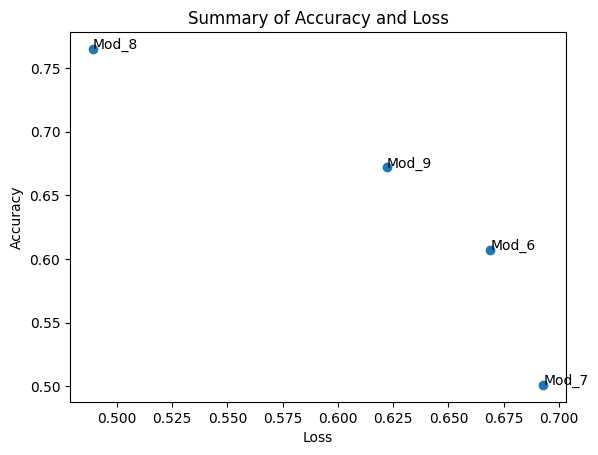

In [ ]:
import matplotlib.pyplot as plt

Model_6 = (0.669, 0.607)
Model_7 = (0.693, 0.501)
Model_8 = (0.489, 0.765)
Model_9 = (0.622, 0.672)

Models_3 = ("Mod_6","Mod_7","Mod_8","Mod_9")
Loss_3 = (Model_6[0],Model_7[0],Model_8[0],Model_9[0])
Accuracy_3 = (Model_6[1],Model_7[1],Model_8[1],Model_9[1])

fig, ax = plt.subplots()
ax.scatter(Loss_3,Accuracy_3)
for i, txt in enumerate(Models_3):
    ax.annotate(txt, (Loss_3[i],Accuracy_3[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")


plt.show()

We can clearly see that the model 8 achieved the highest accuracy of 76.5% and the lowest loss of 48.9% among all the models. Model 7 has the highest loss of 69.3%.

Training Sample 3000, Validation 500, Test 500

In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=3000)
make_subset("validation", start_index=3000, end_index=3500)
make_subset("test", start_index=3500, end_index=4000)


In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
data_augmentation_3 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

Model - 10 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 3000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_3(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model10.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_10 = model.fit(
          train_dataset,
          epochs=10,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/20
188/188 [==============================] - 49s 253ms/step - loss: 0.6944 - accuracy: 0.5212 - val_loss: 0.6632 - val_accuracy: 0.5990
Epoch 2/20
188/188 [==============================] - 47s 249ms/step - loss: 0.6808 - accuracy: 0.5600 - val_loss: 0.6845 - val_accuracy: 0.5510
Epoch 3/20
188/188 [==============================] - 47s 249ms/step - loss: 0.6713 - accuracy: 0.5833 - val_loss: 0.6494 - val_accuracy: 0.6280
Epoch 4/20
188/188 [==============================] - 47s 250ms/step - loss: 0.6539 - accuracy: 0.6193 - val_loss: 0.6408 - val_accuracy: 0.6470
Epoch 5/20
188/188 [==============================] - 47s 248ms/step - loss: 0.6355 - accuracy: 0.6388 - val_loss: 0.6311 - val_accuracy: 0.6650
Epoch 6/20
188/188 [==============================] - 47s 250ms/step - loss: 0.6073 - accuracy: 0.6753 - val_loss: 0.5805 - val_accuracy: 0.7080
Epoch 7/20
188/188 [==============================] - 47s 248ms/step - loss: 0.5889 - accuracy: 0.6937 - val_loss: 0.5714 - val_ac

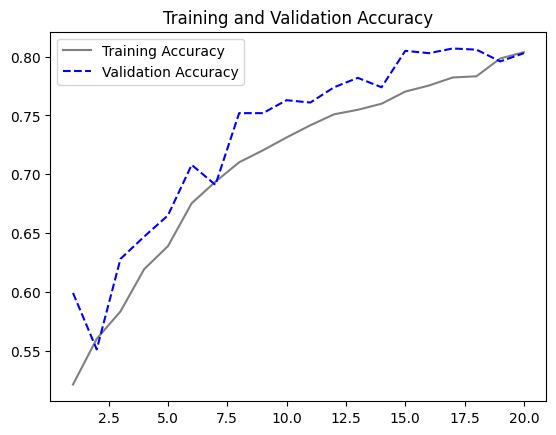

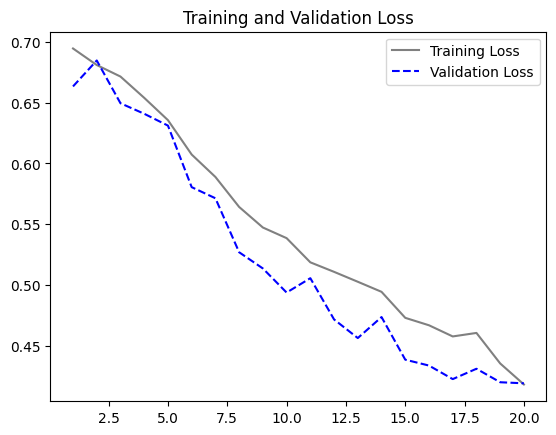

In [ ]:
accuracy = Model_10.history["accuracy"]
val_accuracy = Model_10.history["val_accuracy"]
loss = Model_10.history["loss"]
val_loss = Model_10.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model10.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 54ms/step - loss: 0.4094 - accuracy: 0.8080
Loss: 0.409
Accuracy: 0.808


In summary for Question 3, we constructed four models, three of which were trained with a sample size of 2000. The top-performing model achieved an accuracy of 76.5%. Notably, when we expanded the training sample to 3000, the accuracy increased to 80.8%. Consequently, we deduce that increasing the training sample size to 3000 substantially increased the model's performance.

**4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**

Leveraging a Pre-Trained Model - VGG16

VGG - Model 1 (1000 Training Samples)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
#extracting VGG 16 features and Labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 5s 5s/step


In [ ]:
train_features.shape

(6000, 5, 5, 512)

VGG - Model 1 Dense Layer with 256 Nodes and Droput Rate of 0.3 and optimizer being rmsprop with the Original Images

In [ ]:
# Defining and Training the densely connected classifier
# The last dense stacked layer and the classifier
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


# Compiling the Model

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath="vgg_model1.keras",
            save_best_only=True,
            monitor="val_loss")


# Fitting the model

VGG_Model_1 = model.fit(
              train_features, train_labels,
              epochs=10,
              validation_data=(val_features, val_labels),
              callbacks=callbacks)

Epoch 1/20
188/188 [==============================] - 2s 10ms/step - loss: 10.5026 - accuracy: 0.9500 - val_loss: 3.9554 - val_accuracy: 0.9760
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 3.2467 - accuracy: 0.9793 - val_loss: 3.6357 - val_accuracy: 0.9750
Epoch 3/20
188/188 [==============================] - 2s 9ms/step - loss: 1.1431 - accuracy: 0.9893 - val_loss: 4.0008 - val_accuracy: 0.9780
Epoch 4/20
188/188 [==============================] - 2s 9ms/step - loss: 1.0652 - accuracy: 0.9908 - val_loss: 3.5798 - val_accuracy: 0.9740
Epoch 5/20
188/188 [==============================] - 2s 9ms/step - loss: 0.6462 - accuracy: 0.9942 - val_loss: 4.5418 - val_accuracy: 0.9730
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4569 - accuracy: 0.9942 - val_loss: 3.5438 - val_accuracy: 0.9780
Epoch 7/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2202 - accuracy: 0.9965 - val_loss: 4.0740 - val_accuracy: 0.9750
Epoc

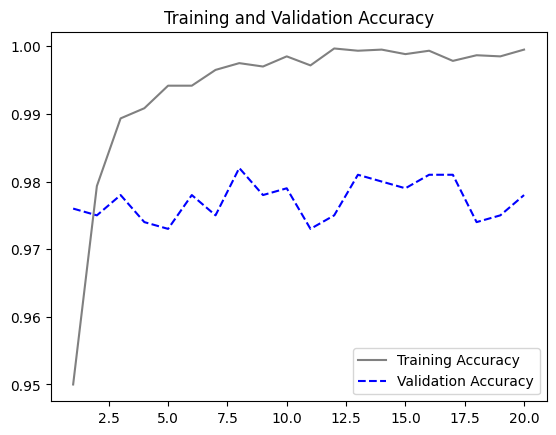

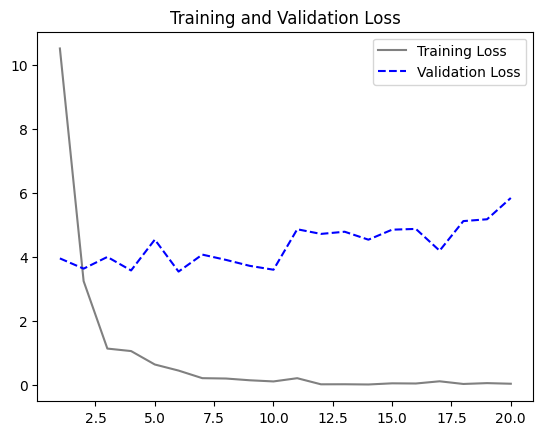

In [ ]:
import matplotlib.pyplot as plt

accuracy = VGG_Model_1.history["accuracy"]
val_accuracy = VGG_Model_1.history["val_accuracy"]
loss = VGG_Model_1.history["loss"]
val_loss = VGG_Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("vgg_model1.keras")
test_loss, test_acc = best_model.evaluate(test_features,test_labels)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 3ms/step - loss: 4.7591 - accuracy: 0.9740
Loss: 4.759
Accuracy: 0.974


VGG - Model 2 (1000 Training Samples)

In [ ]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False

We have configured the pre-trained model to retain its existing weights during training, only allowing the densely connected networks and the classifier to adjust their weights during the training process.

This approach helps prevent overfitting, as the pre-trained model remains unchanged, providing a stable foundation for the model. Moreover, when dealing with limited training data and constrained computational resources, freezing the pre-trained model can be particularly advantageous.

To illustrate the impact of this configuration, we can print the list of trainable weights both before and after freezing the pre-trained model.

In [ ]:
# Before Freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
# After Freezing
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

VGG - Model 2 Dense Layer with 256 Nodes and Droput Rate of 0.3 and optimizer being rmsprop with the Augmented Images

In [ ]:
# Data Augmentation -Adding a data augmentation stage to provide augmented training samples and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)



In [ ]:
# Model compilation
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = [
    ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

# Fitting the model

VGG_Model_2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/20
188/188 [==============================] - 85s 447ms/step - loss: 10.9755 - accuracy: 0.9280 - val_loss: 4.1941 - val_accuracy: 0.9700
Epoch 2/20
188/188 [==============================] - 85s 453ms/step - loss: 4.9294 - accuracy: 0.9555 - val_loss: 2.0615 - val_accuracy: 0.9830
Epoch 3/20
188/188 [==============================] - 85s 453ms/step - loss: 3.2575 - accuracy: 0.9538 - val_loss: 1.0269 - val_accuracy: 0.9820
Epoch 4/20
188/188 [==============================] - 86s 456ms/step - loss: 1.4341 - accuracy: 0.9603 - val_loss: 0.5258 - val_accuracy: 0.9840
Epoch 5/20
188/188 [==============================] - 86s 456ms/step - loss: 0.7059 - accuracy: 0.9663 - val_loss: 0.3017 - val_accuracy: 0.9870
Epoch 6/20
188/188 [==============================] - 83s 441ms/step - loss: 0.5140 - accuracy: 0.9637 - val_loss: 0.3278 - val_accuracy: 0.9770
Epoch 7/20
188/188 [==============================] - 86s 458ms/step - loss: 0.4117 - accuracy: 0.9638 - val_loss: 0.2045 - val_a

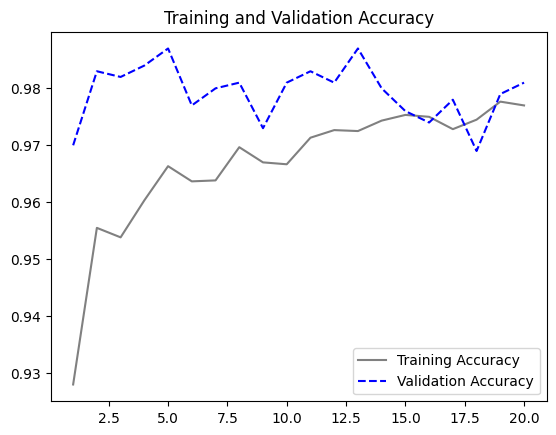

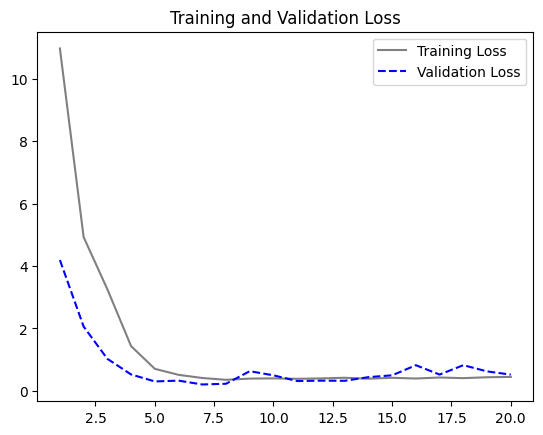

In [ ]:
import matplotlib.pyplot as plt

accuracy = VGG_Model_2.history["accuracy"]
val_accuracy = VGG_Model_2.history["val_accuracy"]
loss = VGG_Model_2.history["loss"]
val_loss = VGG_Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 12s 361ms/step - loss: 0.3768 - accuracy: 0.9760
Loss: 0.377
Accuracy: 0.976


Fine Tuning the VGG_Model_2

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

It is crucial to understand that pre-trained networks are not solely utilized for singular image classification tasks; they are trained to handle diverse use cases and classifications. The initial layers of the network are adept at capturing general features, while the subsequent layers specialize in extracting features specific to the problem at hand. When we opt to freeze the initial layers, we effectively prevent overfitting, enabling the model to assimilate more intricate details pertaining to our specific classification task. This strategic approach encourages the model to focus on learning the nuanced aspects of the target classification problem.


In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath="fine_convnet_from_scratch.x",
            save_best_only=True,
            monitor="val_loss")

# Fitting the model

FineTuned_VGG_Model_2 = model.fit(
                        train_dataset,
                        epochs=10,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/20
188/188 [==============================] - 123s 646ms/step - loss: 0.3143 - accuracy: 0.9830 - val_loss: 0.4705 - val_accuracy: 0.9820
Epoch 2/20
188/188 [==============================] - 120s 639ms/step - loss: 0.2803 - accuracy: 0.9803 - val_loss: 0.4237 - val_accuracy: 0.9820
Epoch 3/20
188/188 [==============================] - 120s 640ms/step - loss: 0.2156 - accuracy: 0.9848 - val_loss: 0.3672 - val_accuracy: 0.9840
Epoch 4/20
188/188 [==============================] - 122s 647ms/step - loss: 0.1837 - accuracy: 0.9855 - val_loss: 0.3068 - val_accuracy: 0.9810
Epoch 5/20
188/188 [==============================] - 121s 646ms/step - loss: 0.1365 - accuracy: 0.9857 - val_loss: 0.2973 - val_accuracy: 0.9830
Epoch 6/20
188/188 [==============================] - 118s 630ms/step - loss: 0.1122 - accuracy: 0.9875 - val_loss: 0.3914 - val_accuracy: 0.9830
Epoch 7/20
188/188 [==============================] - 121s 643ms/step - loss: 0.0958 - accuracy: 0.9907 - val_loss: 0.2724 -

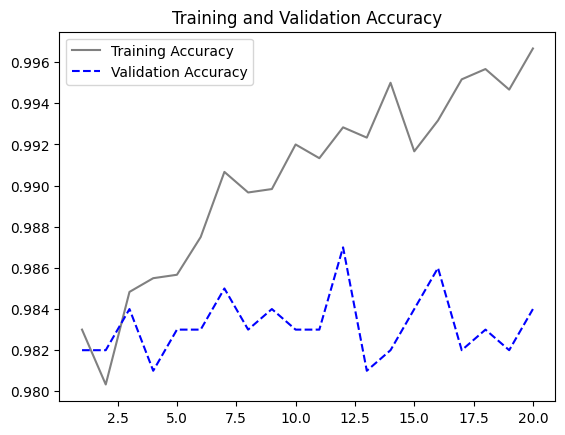

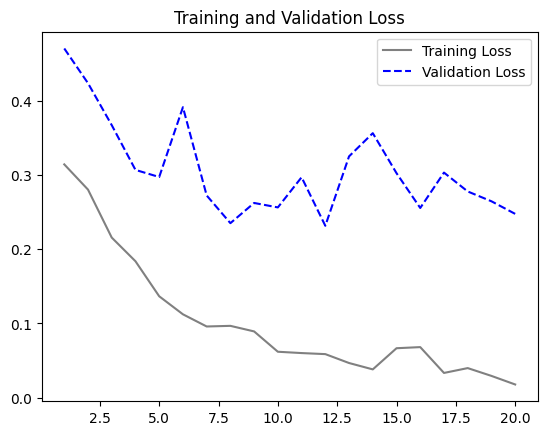

In [ ]:
import matplotlib.pyplot as plt

accuracy = FineTuned_VGG_Model_2.history["accuracy"]
val_accuracy = FineTuned_VGG_Model_2.history["val_accuracy"]
loss = FineTuned_VGG_Model_2.history["loss"]
val_loss = FineTuned_VGG_Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 12s 370ms/step - loss: 0.4241 - accuracy: 0.9830
Loss: 0.424
Accuracy: 0.983


In the analysis of the two VGG16 models, we constructed three models utilizing the pre-trained network VGG16. Notably, we observed that preventing the pre-trained network from updating its weights during training and subsequently freezing the initial layers resulted in higher accuracy. Consequently, we aim to employ the same methodology in building two models using a training sample size of 2000.

VGG - Model 3 (3000 Training Samples)

In [ ]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# Data Augmentation
data_augmentation_4 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_4(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "m3_convnet_from_scratch.x",
            save_best_only= True,
            monitor= "val_loss")

# Fitting the model

VGG_Model_3 = model.fit(
              train_dataset,
              epochs=10,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/30
188/188 [==============================] - 89s 470ms/step - loss: 8.9185 - accuracy: 0.9148 - val_loss: 3.0613 - val_accuracy: 0.9730
Epoch 2/30
188/188 [==============================] - 84s 446ms/step - loss: 4.4842 - accuracy: 0.9425 - val_loss: 3.2034 - val_accuracy: 0.9660
Epoch 3/30
188/188 [==============================] - 87s 465ms/step - loss: 2.1861 - accuracy: 0.9537 - val_loss: 1.7967 - val_accuracy: 0.9660
Epoch 4/30
188/188 [==============================] - 86s 456ms/step - loss: 1.0824 - accuracy: 0.9555 - val_loss: 0.5746 - val_accuracy: 0.9750
Epoch 5/30
188/188 [==============================] - 86s 458ms/step - loss: 0.4660 - accuracy: 0.9563 - val_loss: 0.2289 - val_accuracy: 0.9740
Epoch 6/30
188/188 [==============================] - 87s 461ms/step - loss: 0.2649 - accuracy: 0.9632 - val_loss: 0.1840 - val_accuracy: 0.9740
Epoch 7/30
188/188 [==============================] - 83s 440ms/step - loss: 0.1985 - accuracy: 0.9638 - val_loss: 0.5302 - val_ac

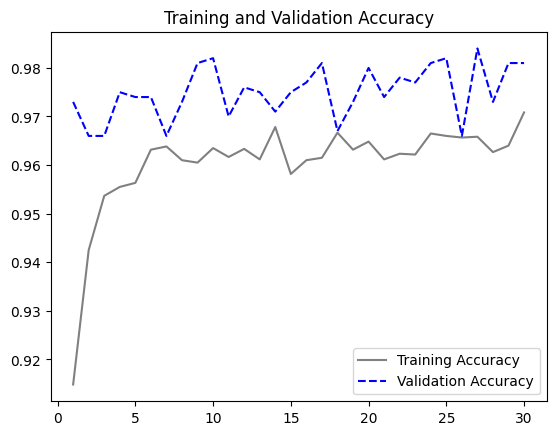

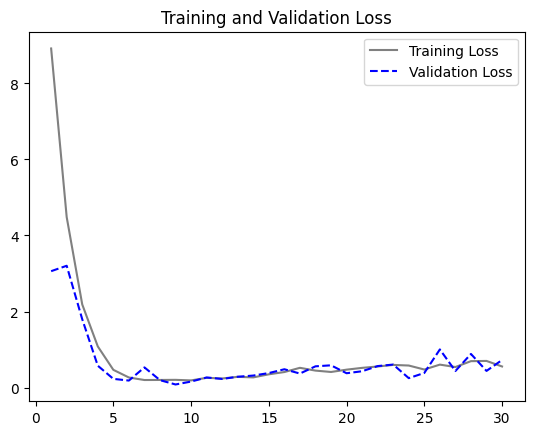

In [ ]:
import matplotlib.pyplot as plt

accuracy = VGG_Model_3.history["accuracy"]
val_accuracy = VGG_Model_3.history["val_accuracy"]
loss = VGG_Model_3.history["loss"]
val_loss = VGG_Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("m3_convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 12s 357ms/step - loss: 0.2014 - accuracy: 0.9780
Loss: 0.201
Accuracy: 0.978


Fine Tunning VGG_Model_3 (Training Samples - 3000)

In our efforts to optimize VGG_Model3, we have chosen to freeze the initial four layers. This strategy aims to prevent the model from overfitting and allows it to concentrate solely on learning the distinctive features relevant to our particular classification task. Consequently, we have configured the pre-trained layers to remain unaltered during training while ensuring that the first four layers remain frozen. These optimizations are instrumental in enhancing the model's performance when dealing with a training sample size of 3000.

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath="fine_m3_convnet_from_scratch.x",
            save_best_only=True,
            monitor="val_loss")

# Fitting the model

FineTuned_VGG_Model_3 = model.fit(
                        train_dataset,
                        epochs=10,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt

accuracy = FineTuned_VGG_Model_3.history["accuracy"]
val_accuracy = FineTuned_VGG_Model_3.history["val_accuracy"]
loss = FineTuned_VGG_Model_3.history["loss"]
val_loss = FineTuned_VGG_Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_m3_convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

Having constructed a total of 15 models, including two fine-tuned versions, we aim to conduct a comparative analysis to identify the best-performing models in two categories: Scratch Models and Pre-Trained Models. Our immediate focus is to evaluate the best model developed from scratch. This evaluation involves comparing the loss and accuracy metrics across 10 models built with varying configurations and training sample sizes for classifying cats and dogs.

Model 1: Filters from 32 to 256, 5 Input Layers

Model 2: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.5

Model 3: Filters from 32 to 512, 6 Input Layers, Augmented Images, Dropout rate of 0.5

Model 4: Filters from 64 to 1024, 5 Input Layers, Augmented Images, Dropout rate of 0.6

Model 5: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Size - 1500

Model 6: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Size - 1500, Padding set to 'Same'

Model 7: MaxPooling Operation, Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Sample - 2000

Model 8: MaxPooling + Strides of Step-Size 2, Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Sample - 2000

Model 9: MaxPooling + Strides of Step-Size 2 with Padding turned on, Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Sample - 2000

Model 10: Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Size - 3000

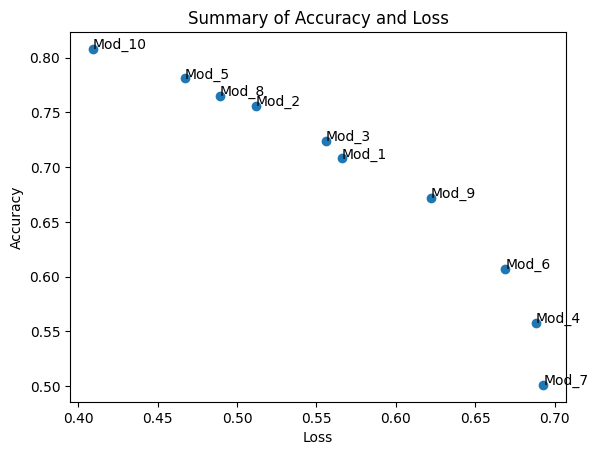

In [ ]:
import matplotlib.pyplot as plt

# Scratch Models
Model_1 = (0.566, 0.708)
Model_2 = (0.512, 0.756)
Model_3 = (0.556, 0.724)
Model_4 = (0.688, 0.558)
Model_2 = (0.512, 0.756)
Model_5 = (0.467, 0.781)
Model_6 = (0.669, 0.607)
Model_7 = (0.693, 0.501)
Model_8 = (0.489, 0.765)
Model_9 = (0.622, 0.672)
Model_10 = (0.409, 0.808)


Models_4 = ("Mod_1","Mod_2","Mod_3","Mod_4","Mod_5","Mod_6","Mod_7","Mod_8","Mod_9","Mod_10")
Loss_4 = (Model_1[0],Model_2[0],Model_3[0],Model_4[0],Model_5[0],Model_6[0],Model_7[0],Model_8[0],Model_9[0],Model_10[0])
Accuracy_4 = (Model_1[1],Model_2[1],Model_3[1],Model_4[1],Model_5[1],Model_6[1],Model_7[1],Model_8[1],Model_9[1],Model_10[1])

fig, ax = plt.subplots()
ax.scatter(Loss_4,Accuracy_4)
for i, txt in enumerate(Models_4):
    ax.annotate(txt, (Loss_4[i],Accuracy_4[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")


plt.show()

Among the scratch models, Model 10 trained with 3000 samples emerged as the top-performing model, achieving an impressive 80.8% accuracy and a 40.9% loss on the test set.

Next, we built 5 models using the pre-trained VGG16 network. The first 3 models were trained with 1000 samples using RMSprop as the optimizer, while the remaining 2 models were trained with 3000 samples using Adam as the optimizer.

VGG Models:

  VGG 1: Filters from 32 to 256, 5 Input Layers

  VGG 2: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.3

  VGG 3: Filters from 32 to 512, 6 Input Layers, Augmented Images, Dropout rate of 0.3

  VGG 4: VGG - Model 3 (3000 Training Samples)

  VGG 5: Fine-Tuning VGG_Model_3 (Training Samples - 3000)

In [ ]:
# Pre-Trained Models
VGG_Model_1 = (4.759,0.974)
VGG_Model_2 = (0.377,0.976)
FineTuned_VGG_Model_2 = (0.424,0.983)
VGG_Model_3 = (0.201,0.978)
FineTuned_VGG_Model_3 = (0.152,0.987)

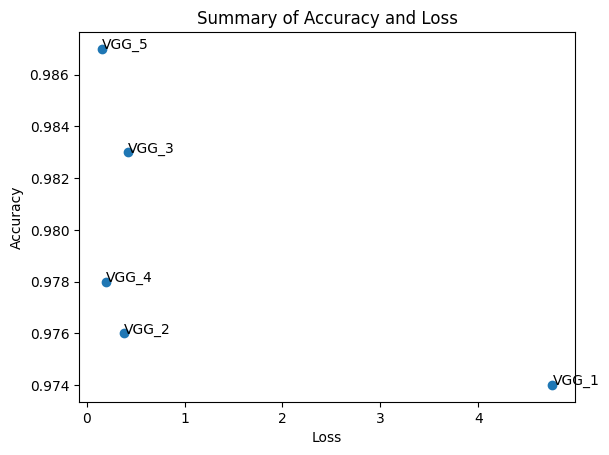

In [ ]:
import matplotlib.pyplot as plt

Models_5 = ("VGG_1","VGG_2","VGG_3","VGG_4","VGG_5")
Loss_5 = (VGG_Model_1[0],VGG_Model_2[0],FineTuned_VGG_Model_2[0],VGG_Model_3[0],FineTuned_VGG_Model_3[0])
Accuracy_5 = (VGG_Model_1[1],VGG_Model_2[1],FineTuned_VGG_Model_2[1],VGG_Model_3[1],FineTuned_VGG_Model_3[1])

fig, ax = plt.subplots()
ax.scatter(Loss_5,Accuracy_5)
for i, txt in enumerate(Models_5):
    ax.annotate(txt, (Loss_5[i],Accuracy_5[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")


plt.show()

In the realm of pre-trained models, it was Model_5 (VGG_Model_3) and Model_4 (FineTuned_VGG_Model_3) that stood out as the top performers, boasting an impressive 98% accuracy and a mere 15% loss. These models were constructed with 3000 training samples respectively, and were optimized using the Adam optimizer with a learning rate of 0.000001.